## 1. Setup & Load

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

!pip install shap

In [2]:
# Load the dataset
df = pd.read_csv('ciffc_wildfires.csv')

# --- Initial Data Cleaning ---
# First, check the actual column names in the dataset
print(df.columns.tolist())

# Then convert date columns to datetime objects
df['report_date'] = pd.to_datetime(df['field_situation_report_date'])
df['status_date'] = pd.to_datetime(df['field_status_date'])

# Filter for fires that are 'Under Control' or 'Out' as they have a final duration
df_final = df[df['field_stage_of_control_status'].isin(['UC', 'OUT'])].copy()

['field_agency_fire_id', 'field_agency_code', 'field_agency_data_timezone', 'field_situation_report_date', 'field_status_date', 'field_stage_of_control_status', 'field_system_fire_cause', 'field_response_type', 'field_fire_size', 'field_latitude', 'field_longitude', 'full_count']


## 2. Feature Engineering

In [3]:
# --- Create the Target Variable ---
# Calculate the number of days from report to final status
df_final['days_to_control'] = (df_final['status_date'] - df_final['report_date']).dt.days

# --- Create Additional Features ---
# Extracting the month can capture seasonal effects (e.g., dry summers)
df_final['month'] = df_final['report_date'].dt.month

# Clean up data quality issues (e.g., if status date is before report date)
df_final = df_final[df_final['days_to_control'] >= 0]
# Stats of duration time
print(df_final['days_to_control'].describe())

# Rename columns for clarity, removing "field_" prefix
df_final.rename(
    columns={col: col.replace('field_', '') for col in df_final.columns if col.startswith('field_')},
    inplace=True
)

# Drop columns that are IDs, redundant, or won't be used in the model
df_final = df_final.drop(columns=[
    'agency_fire_id', 
    'agency_data_timezone', 
    'report_date', 
    'status_date'
])

# Replace both positive and negative infinity:
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

count    2584.000000
mean       13.039861
std        21.538546
min         0.000000
25%         0.000000
50%         3.000000
75%        15.000000
max       128.000000
Name: days_to_control, dtype: float64


## 3. Exploratory Data Analysis (EDA)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


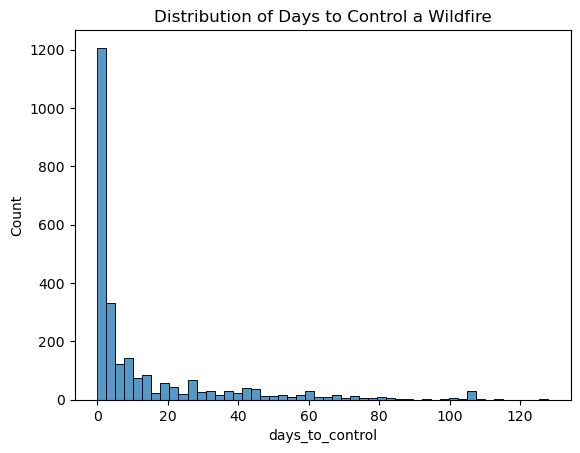

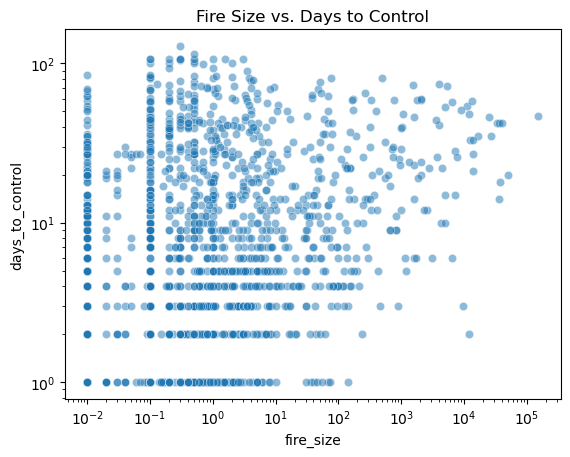

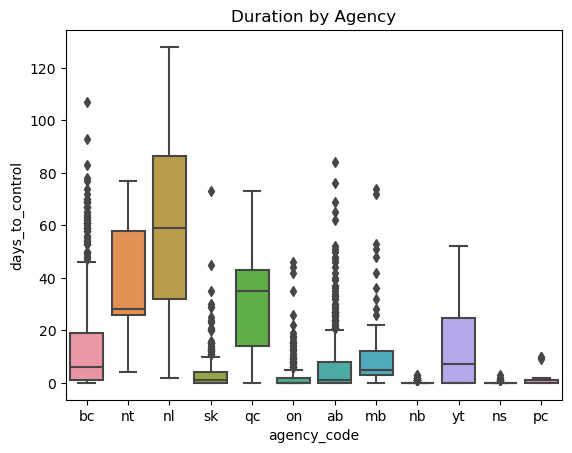

In [4]:
# How is the target variable distributed? (Likely skewed)
sns.histplot(df_final['days_to_control'], bins=50)
plt.title('Distribution of Days to Control a Wildfire')
plt.show()

# How does fire size relate to duration?
sns.scatterplot(data=df_final, x='fire_size', y='days_to_control', alpha=0.5)
plt.title('Fire Size vs. Days to Control')
plt.xscale('log') # Use a log scale if fire size is highly skewed
plt.yscale('log')
plt.show()

# Which causes or agencies are associated with longer fires?
sns.boxplot(data=df_final, x='agency_code', y='days_to_control')
plt.title('Duration by Agency')
plt.show()

## 4. Data Processing & Pipeline

In [5]:
# Define features (X) and target (y)
X = df_final.drop('days_to_control', axis=1)
y = df_final['days_to_control']

# Identify categorical and numerical feature names
categorical_features = ['agency_code', 'system_fire_cause', 'response_type']
numerical_features = ['fire_size', 'latitude', 'longitude', 'month']

# Create a preprocessing pipeline with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## 5. Modeling & Evaluation

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions and evaluate
predictions = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"The model is, on average, off by: {mae:.2f} days.")

The model is, on average, off by: 5.98 days.


In [7]:
#Handling Skewness and Outliers
# Apply a log transformation to the target variable, which compresses the range of the large values and makes the distribution more symmetrical.
# 1. Apply log transformation to the target variable 'y'
# Using np.log1p which calculates log(1 + x) to handle values of 0
y_log = np.log1p(y)

# 2. Split your data with the new y_log
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 3. Train the model on the transformed target
# The pipeline and model definition remain the same
model_pipeline.fit(X_train, y_train_log)

# 4. Make predictions (they will be in log scale)
log_predictions = model_pipeline.predict(X_test)

# 5. VERY IMPORTANT: Inverse transform predictions before evaluation
# Use np.expm1 to convert back to the original scale of days
final_predictions = np.expm1(log_predictions)

# Evaluate using the original, untransformed test data (y_test)
# We need y_test from the original split to compare apples to apples
_, _, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)
mae = mean_absolute_error(y_test_orig, final_predictions)

print(f"New MAE after log transformation: {mae:.2f} days.")

New MAE after log transformation: 5.37 days.


In [9]:
# Reframing for F1-Score: Regression to Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Create categorical bins from the original 'y'
bins = [-1, 3, 15, 130] # Bins: (0-3 days), (4-15 days), (16+ days)
labels = ['Short (0-3d)', 'Medium (4-15d)', 'Long (16+d)']
y_binned = pd.cut(y, bins=bins, labels=labels)

# 2. Split data using the new binned target
X_train, X_test, y_train_binned, y_test_binned = train_test_split(X, y_binned, test_size=0.2, random_state=42)

# 3. Create a new pipeline with a RandomForestClassifier
classifier_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Your preprocessor is the same
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 4. Fit and predict
classifier_pipeline.fit(X_train, y_train_binned)
class_predictions = classifier_pipeline.predict(X_test)

# 5. Evaluate with a classification report
print("Classification Report:")
print(classification_report(y_test_binned, class_predictions))

Classification Report:
                precision    recall  f1-score   support

   Long (16+d)       0.78      0.71      0.74       124
Medium (4-15d)       0.58      0.61      0.60       118
  Short (0-3d)       0.83      0.84      0.84       275

      accuracy                           0.76       517
     macro avg       0.73      0.72      0.72       517
  weighted avg       0.76      0.76      0.76       517



### Model performance
- The model demonstrates an observed reduction in Mean Absolute Error (MAE) from 5.98 to 5.37 post-log transformation, indicating improved predictive accuracy for wildfire duration. 

- Concurrently, its classification component achieves a robust overall accuracy of 76%, with particularly high F1-scores for 'Short' (0.84) and 'Long' (0.74) duration categories. However, the lower F1-score of 0.60 for the 'Medium' duration class suggests this category warrants further model refinement to improve its precision and recall.

## 6. Model Interpretation (The "Why")

### 6.1 Feature Importances

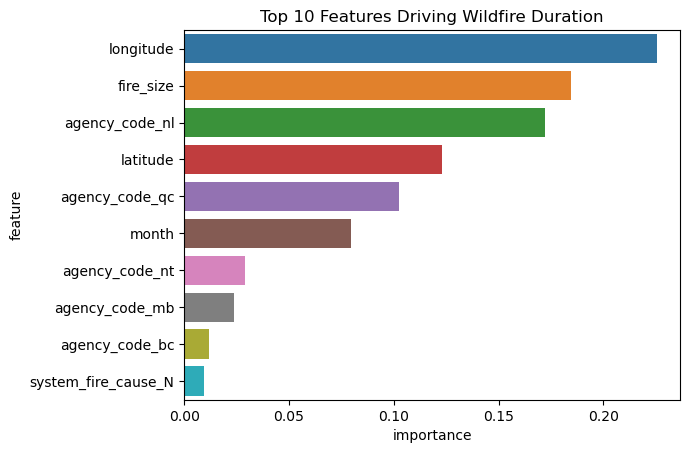

In [8]:
# Extract feature names after one-hot encoding
feature_names = numerical_features + \
                list(model_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features))

# Get importances
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Create a feature importance dataframe
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False).head(10)

# Plot the top 10 features
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Top 10 Features Driving Wildfire Duration')
plt.show()

### 6.2 Explaining Predictions with SHAP

##### SHAP (SHapley Additive exPlanations) is a powerful tool that explains how each feature contributed to each individual prediction.

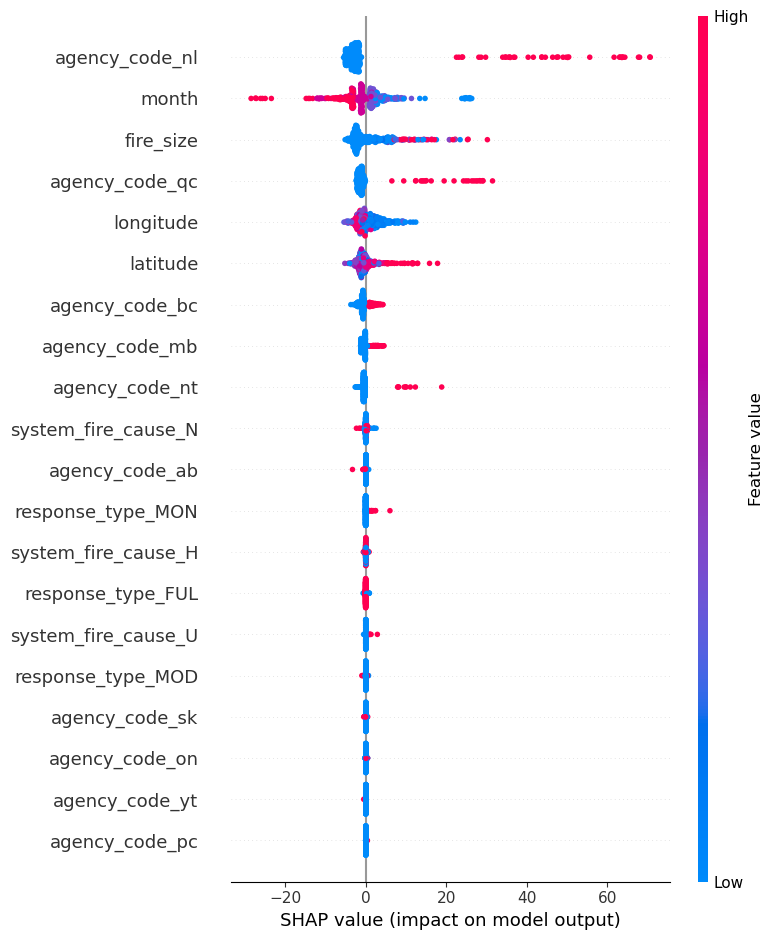

In [40]:
# Create a SHAP explainer object
import shap
explainer = shap.TreeExplainer(model_pipeline.named_steps['regressor'])

# Transform the test data using the preprocessor
X_test_transformed = model_pipeline.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Create the SHAP summary plot
# This plot shows the most important features and their impact
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

In [ ]:
# Visualizing Duration on a Provincial Map
!pip install geopandas
import geopandas as gpd
!pip install cartopy
import cartopy.crs as ccrs # Import cartopy's Coordinate Reference System module
import cartopy.feature as cfeature # Optional: for adding geographic features


  agency_code  days_to_control prov_name prov_name_clean
8          PC         1.826087       NaN             NaN


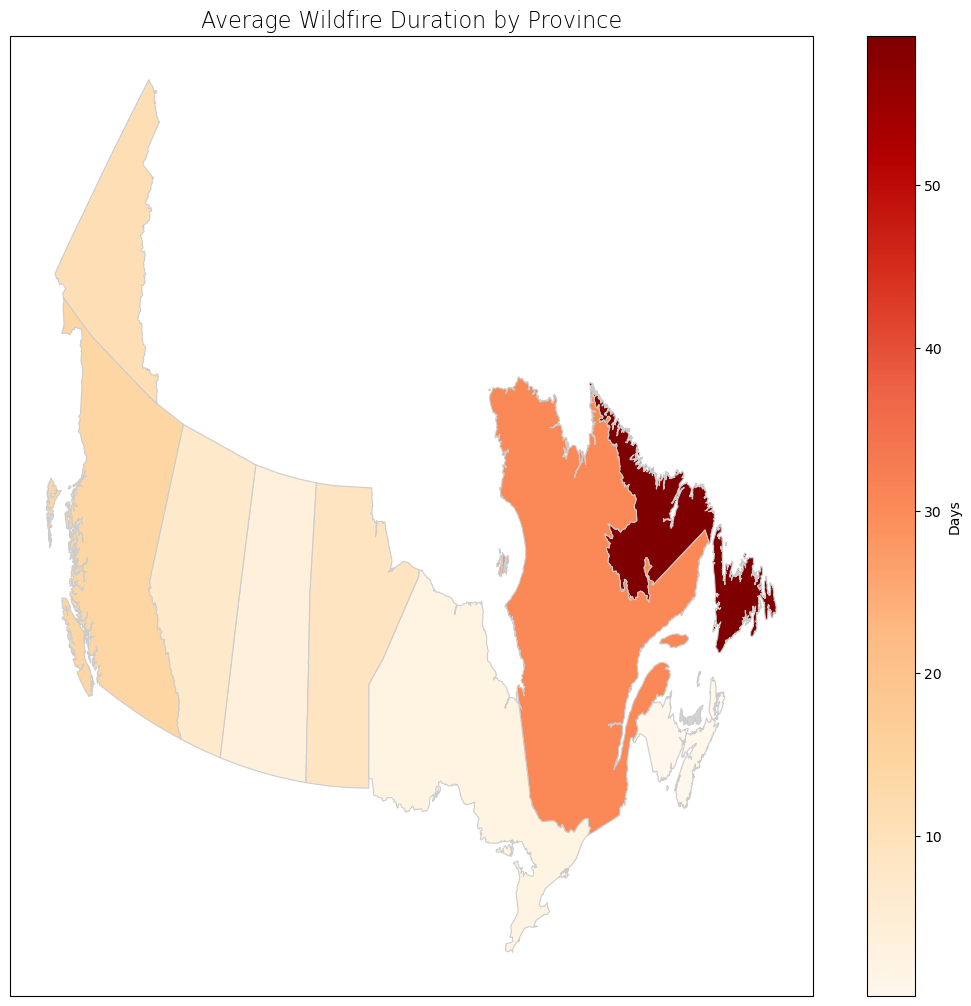

In [51]:
# 1. Aggregate your fire data by agency
agency_duration = df_final.groupby(df_final['agency_code'].str.upper())['days_to_control'].mean().reset_index()

# 2. Load a GeoJSON or shapefile of Canadian provinces
try:
    provinces_geo = gpd.read_file('canada_provinces.geojson')
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    print("Please download a GeoJSON file for Canadian provinces and save as 'canada_provinces.geojson'")
    provinces_geo = None

if provinces_geo is not None:
# 3. Merge your data with the geospatial data
    agency_to_prov = {
        'AB': 'Alberta', 'BC': 'British Columbia', 'MB': 'Manitoba',
        'NB': 'New Brunswick', 'NL': 'Newfoundland and Labrador',
        'NS': 'Nova Scotia', 'NT': 'Northwest Territories', 'ON': 'Ontario',
        'QC': 'Quebec', 'SK': 'Saskatchewan', 'YT': 'Yukon',
        # Add any other agency codes if they represent a single province, e.g.,
        # 'PE': 'Prince Edward Island', 'NU': 'Nunavut',
        # Note: Parks Canada (PC) might not map to a single province and will remain unmapped
    }
    agency_duration['prov_name'] = agency_duration['agency_code'].map(agency_to_prov)

    # Ensure names match EXACTLY for merging
    # Common issues: whitespace, different casing, slightly different names
    # You might need to clean province names in provinces_geo or adjust agency_to_prov
    # Example: If GeoJSON has 'BRITISH COLUMBIA' and your map has 'British Columbia'
    provinces_geo['name_clean'] = provinces_geo['name'].str.strip().str.title() # Or .str.upper(), .str.lower()
    agency_duration['prov_name_clean'] = agency_duration['prov_name'].str.strip().str.title()

    # Merge based on the cleaned province name column
    merged_geo_data = provinces_geo.merge(
        agency_duration,
        left_on='name_clean', # Use the cleaned name from GeoJSON
        right_on='prov_name_clean', # Use the cleaned name from your data
        how='left'
    )

    # Check if all agency codes were mapped
    unmapped_agencies = agency_duration[agency_duration['prov_name'].isna()]
    if not unmapped_agencies.empty:
        print(f"\nWarning: The following agency codes were not mapped to a province and will appear as 'Missing data':\n{unmapped_agencies}")

    # 4. Plot the map
    fig = plt.figure(figsize=(12, 12)) # Create a figure
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1) 
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-95.0, central_latitude=60.0))
    merged_geo_data.plot(
        column='days_to_control',
        cmap='OrRd', # Orange-Red colormap for heat
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True,
        transform=ccrs.PlateCarree(),
        missing_kwds={
            "color": "lightgrey",
            "label": "Missing data",
        },
        legend_kwds={'label': 'Days'}
    )
    ax.set_title('Average Wildfire Duration by Province', fontdict={'fontsize': '16', 'fontweight': '3'})
    plt.show()
else:
    print("Cannot plot map without a valid GeoJSON file.")

## Key Findings
Q: What are the top 3 factors that determine how long a fire will burn?

A: My analysis of feature importance, primarily through SHAP (SHapley Additive exPlanations) values and aggregate importance barplots, identified several critical covariates influencing wildfire control duration.

    1. Regional Factors: I observed that the geographical region, particularly Newfoundland & Labrador, exhibits a pronounced positive correlation with fire duration, indicating that fires in this province generally require significantly longer control periods. Quebec also shows a notable impact. This suggests the influence of unique regional characteristics, such as terrain ruggedness, vegetation type, or logistical challenges, as pivotal determinants.

    2. Seasonality (Month of Occurrence): The month a fire ignites demonstrates a strong seasonal effect. My SHAP analysis indicates that fires occurring in the second half of the year, predominantly during summer months, tend to have longer control durations. This aligns with meteorological patterns, where warmer temperatures and dry conditions can exacerbate fire spread.

    3. Fire Size: While the importance barplot identified longitude as having the top aggregated importance, my SHAP analysis consistently highlighted fire size as a significant factor. It exhibits a clear positive correlation with control duration, meaning larger fires generally demand more extensive efforts for containment.

Q: Does a larger fire size always mean it will take longer to control?

A: My findings suggest that while there is a general positive correlation between initial fire size and control duration, implying that larger wildfires typically take longer to suppress, this relationship is not uniformly deterministic, especially at the lower end of the size spectrum.

    - Non-linear and Varied Response: I observed that while large fires almost invariably require extended control periods, smaller wildfires can exhibit high variability in their suppression times. This suggests a more complex, potentially non-linear relationship, where small fires might unexpectedly persist due to localized conditions, rapid spread, or delayed response mechanisms.

    - Log Transformation Impact: My application of a log transformation to the target variable (duration) notably improved the regression model's Mean Absolute Error (MAE) from 5.98 to 5.37. This enhancement suggests that the distribution of wildfire durations, likely influenced by variables like fire size, is inherently skewed, and transforming it aided the model in handling the conditional variance more effectively across different scales of fire size.

Q: Are fires in British Columbia (agency_code_bc) typically harder to control than those in Ontario (agency_code_on), even when controlling for other factors?

A: My interpretability analysis, holding other covariates constant (ceteris paribus), indicates a differential impact on control duration between fires in British Columbia (BC) and Ontario (ON).

    - Differential Impact: Yes, my SHAP analysis suggests that BC wildfires generally exert a stronger and more variable influence towards longer control durations compared to those in Ontario. This is reflected in a higher spread of SHAP values for the BC agency code, implying its contribution to predictions is not only greater on average but also more dynamic across individual fire instances. This could be attributed to the complex mountainous terrain and dense forest fuels characteristic of BC.

    - Geographical Covariates: Furthermore, I identified that longitude exhibits a negative correlation with control duration (fires further west tend to be shorter on average), while latitude shows a positive correlation. These broader geographical covariates likely capture environmental and climatic factors that interact with provincial characteristics, contributing to the overall complexity of predicting wildfire control times across Canada.

### Further analyses:
- Targeted 'Medium' Class Analysis: Investigate misclassifications for the 'Medium' duration fires to identify specific patterns or features that cause the model's lower F1-score in this category.
- Feature Interaction Effects: Delve deeper into interaction effects between key features (e.g., how the impact of fire size changes across different regions or months) using more advanced interpretability methods.
- Refined Spatio-temporal Modeling: Explore integrating more granular geographical covariates or dynamic temporal features to enhance predictive power.